# File upload

In [1]:
#########     preparation block       #########
#   install mne package & upload eeg data files
###############################################
!pip install mne

from google.colab import files
uploaded = files.upload()

ModuleNotFoundError: No module named 'google'

# data initialization

In [2]:
import os
import sys
import mne
import matplotlib.pyplot as plt
import time
plt.style.use('default')
import scipy.io as sio
import numpy as np
from scipy import signal
from scipy import fft
from scipy import stats 
import array as arr
from pandas import DataFrame
import pandas as pd 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [3]:



START_ARG=0
STOP_ARG=240000
NumOfChannels = 70
vhdr_file = 'EEG_Data_03.vhdr'
raw_data = mne.io.read_raw_brainvision(vhdr_file, misc='auto', scale=1000.0)
elec_names = raw_data.ch_names
data_info = (raw_data.get_data(start=START_ARG,stop = STOP_ARG))
dataFft = fft.fft(data_info,axis = 1)
#### define important electrodes ####
key_elecs = ['Fz','FCz','Cz','CPz','Pz']
for i in range(6):
    key_elecs.append('F' + str(i+1))
    key_elecs.append('C' + str(i+1))
    key_elecs.append('CP' + str(i+1))
    key_elecs.append('P' + str(i+1))
    key_elecs.append('FC' + str(i+1))

##### filter key elec channels #####
key_inds = []
for ind,ch_name in enumerate(elec_names):
    if ch_name in key_elecs:
        key_inds.append(ind)

key_data = data_info[key_inds]

#####   data filtering block  #####
zi_notch=[]
zi_band=[]
welch_1=18
welch_2=24
idx_topo=np.array(range(64))
freq_1_y=20
freq_2_y=20
order = 4
fs = 500
lowcut = 8
highcut = 26
nyq = 0.5 * fs
low = lowcut / nyq
high = highcut / nyq
      
f0 = 50.0  # Frequency to be removed from signal (Hz)
Q = 30.0  # Quality factor
        #Design notch filter
        
b_notch, a_notch = signal.iirnotch(f0, Q, fs)
b_band, a_band = signal.butter(order, [low, high], btype='band')

#zi_notch = signal.lfilter_zi(b_notch,a_notch)
#zi_band = signal.lfilter_zi(b_band,a_band)
for i in range(np.size(key_data,0)):
  zi_notch.append(signal.lfilter_zi(b_notch, a_notch))
  zi_band.append(signal.lfilter_zi(b_band, a_band))
def Filter_data(data, a_notch,b_notch,a_band,b_band,zi_notch,zi_band):
        #  FILTERING DATA           
        # =============================================================================
       data, zi_notch = signal.lfilter(b_notch, a_notch, data, axis=1, zi=zi_notch)
       data, zi_band = signal.lfilter(b_band, a_band, data, axis=1, zi=zi_band)
       #zi_notch = zf_notch
       #zi_band = zf_band
       return data, zi_notch,zi_band

def Filter_data_filtfilt(data, a_notch,b_notch,a_band,b_band,zi_notch,zi_band):
        #  FILTERING DATA           
        # =============================================================================
       data = signal.filtfilt(b_notch, a_notch, data, axis=1)
       data = signal.filtfilt(b_band, a_band, data, axis=1)
       #zi_notch = zf_notch
       #zi_band = zf_band
       return data









Extracting parameters from EEG_Data_03.vhdr...
Setting channel info structure...


# Pre & Post filter FFT check

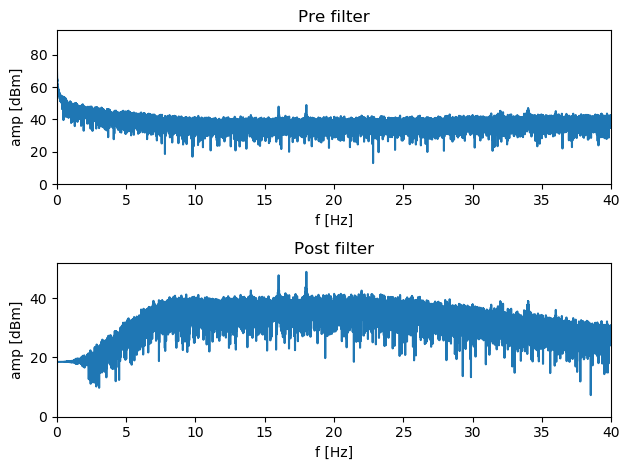

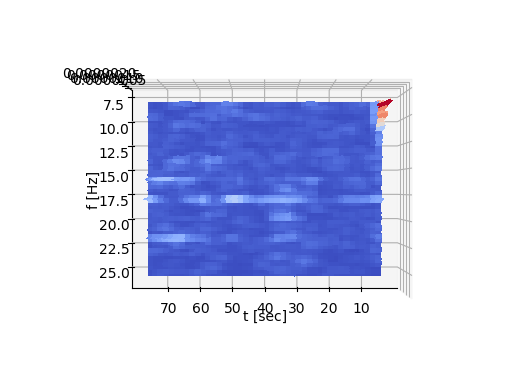

<Figure size 640x480 with 0 Axes>

In [4]:
fig, (ax_o, ax_filt) = plt.subplots(2, 1,sharex=True)

plt.subplot(2, 1, 1)
f = fft.fftshift(fft.fft(key_data[1][10100:]))
xf = np.linspace(-fs/2, (fs/2)-(fs/np.size(f)), np.size(f))
plt.plot(xf,(10.0 * np.log10(np.abs(f))+30))
plt.title('Pre filter')
plt.xlabel('f [Hz]')
plt.ylabel('amp [dBm]')
plt.xlim(left = 0, right = 40)
plt.ylim(bottom = 0)
#plt.plot((key_data[15]));

filtered_key_data, zi_notch , zi_band = Filter_data(key_data, a_notch,b_notch,a_band,b_band,zi_notch,zi_band)
#plt.plot((filtered_key_data[15][100:]));
f_filt = fft.fftshift(x = fft.fft(filtered_key_data[1][10100:]))
plt.subplot(2, 1, 2)
plt.plot(xf,((10.0 * np.log10(np.abs(f_filt)))+30))
plt.title('Post filter')
plt.xlabel('f [Hz]')
plt.ylabel('amp [dBm]')
plt.xlim(left = 0, right = 40)
plt.ylim(bottom = 0)
plt.tight_layout()
plt.show()

########## Spectrogram try  ###########

fig = plt.figure()
ax = fig.gca(projection='3d')

f_1, t_1, spectro1  = signal.spectrogram(filtered_key_data[1][20000:60000],fs=fs,nperseg=4096,noverlap=0.95*4096,scaling='spectrum')
f_1_crop=f_1[(f_1<=(highcut)) & (f_1>=(lowcut))]
spectro1_crop=2*(abs(spectro1[:][(f_1<=(highcut)) & (f_1>=(lowcut))]))
X, Y = np.meshgrid(t_1, f_1_crop)
surf = ax.plot_surface(X, Y,
                          spectro1_crop,
                          cmap=cm.coolwarm,
                          linewidth=0,
                          antialiased=False)
ax.view_init(90, 90)
ax.set_xlabel('t [sec]')
ax.set_ylabel('f [Hz]')
fig = plt.figure()
#plt.specgram(filtered_key_data[1][20000:40000],NFFT = 4096, Fs = fs, noverlap=0.95*4096, scale='dB')
#plt.show

# Scipy Correlation check

Before filtering

<function matplotlib.pyplot.show(*args, **kw)>

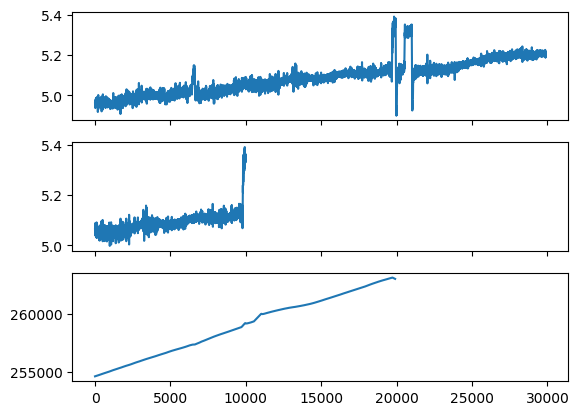

In [5]:
fig, (ax_sig, ax_kernel, ax_corr) = plt.subplots(3, 1, sharex=True)

### Correl
corr_cz = signal.correlate(key_data[1][100:30000],key_data[1][10000:20000],mode='valid')
np.size(corr_cz)
#time = np.arange(0,5000,1)

ax_sig.plot(key_data[1][100:30000])
ax_kernel.plot(key_data[1][10000:20000])
ax_corr.plot(corr_cz)
plt.show

After Filtering

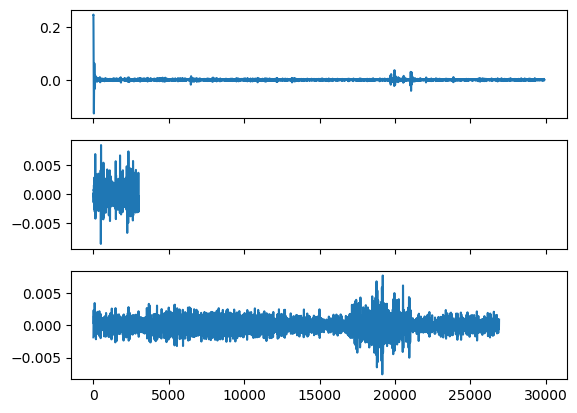

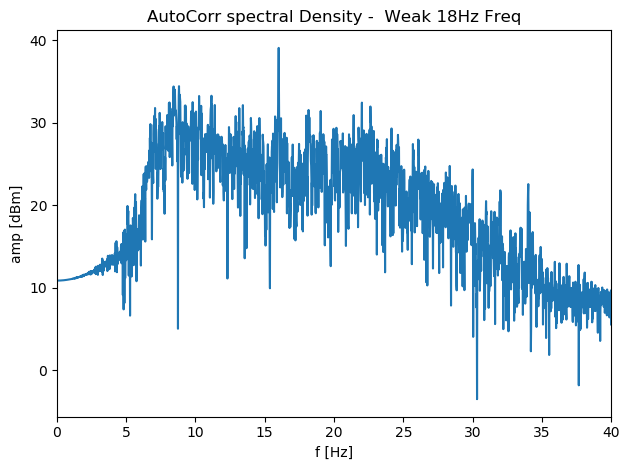

In [6]:
### Correl
kenrel_start_index = 30000
kenrel_stop_index = 33000
corr_cz = signal.correlate(filtered_key_data[1][100:30000],filtered_key_data[1][kenrel_start_index:kenrel_stop_index],mode='valid')
np.size(corr_cz)
corr_fft = fft.fftshift(fft.fft(corr_cz))
f_axis = np.linspace(-fs/2,fs/2,np.size(corr_fft))
#time = np.arange(0,5000,1)
fig, (ax_sig, ax_kernel, ax_corr) = plt.subplots(3, 1,sharex=True)
ax_sig.plot(filtered_key_data[1][100:30000])
ax_kernel.plot(filtered_key_data[1][kenrel_start_index:kenrel_stop_index])
ax_corr.plot(corr_cz)
fig = plt.figure()
plt.plot(f_axis,(10*np.log10(np.abs(corr_fft))+30))
plt.xlim(left=0,right=40)
plt.title('AutoCorr spectral Density -  Weak 18Hz Freq')
plt.xlabel('f [Hz]')
plt.ylabel('amp [dBm]')
##### Notice - the given example doenst have 18Hz Freq
plt.tight_layout()
plt.show()

# Understanding the sum of sines behaviour

Simple behaviour observasion

array([3.15033668])

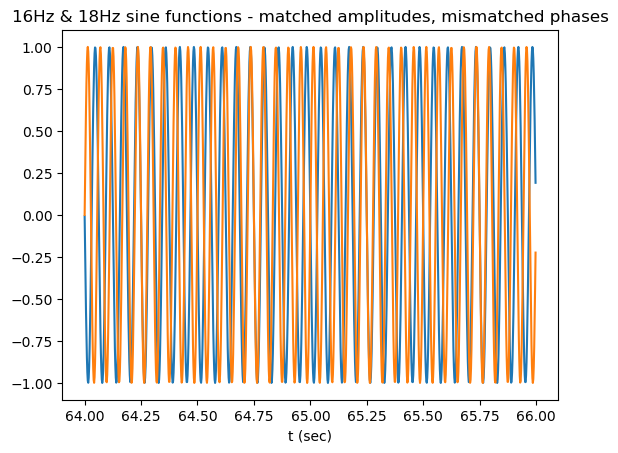

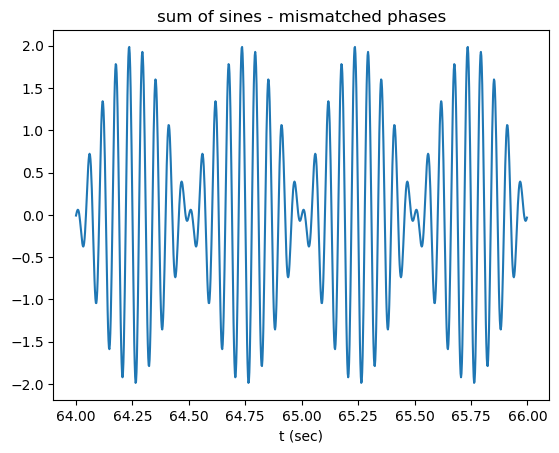

In [7]:
start_ind = 32000
end_ind = 33000
t = np.linspace(start_ind,end_ind,end_ind - start_ind+1) * 1/fs;
t = t[0:-1]
f_16 = 16
f_18 = 18

rand_ph = 2 * np.pi * np.random.rand(1)
sine_16 = np.sin(2 * np.pi * f_16 * t + rand_ph);
sine_18 = np.sin(2 * np.pi * f_18 * t);

plt.plot(t,sine_16);
plt.plot(t, sine_18)
plt.xlabel("t (sec)")

plt.title("16Hz & 18Hz sine functions - matched amplitudes, mismatched phases")
fig = plt.figure()

plt.plot(t, sine_16+sine_18)
plt.title("sum of sines - mismatched phases")
plt.xlabel("t (sec)")
rand_ph

display with eegData

Text(0.5, 1.0, 'EEg FCz electrode & sum of sines - mismatched phases & amplitudes')

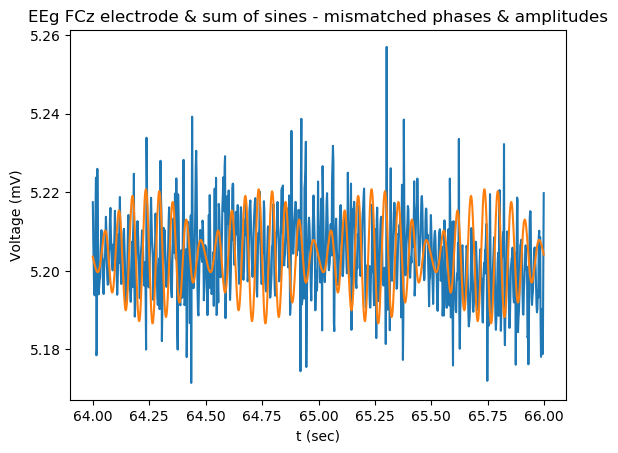

In [8]:
chosenElec = 1 # FCz

plt.plot(t,key_data[chosenElec][start_ind:end_ind])
# setting one of the amplitudes as the stddev of the EEG signal, the other is randomized from uniform distribution in range [amp1/2 amp1]
amp1 = np.std(key_data[chosenElec][start_ind:end_ind]) 
amp2 = np.random.uniform(low=amp1/2, high=amp1)


# the key_data average is set as the DC level for the sum of sines
sum_of_sines = np.average(key_data[chosenElec][start_ind:end_ind]) + amp1*(sine_16 + amp2/amp1*sine_18)


plt.plot(t,sum_of_sines)
plt.xlabel("t (sec)")
plt.ylabel("Voltage (mV)")
plt.title("EEg FCz electrode & sum of sines - mismatched phases & amplitudes")


Adding white noise

Text(0.5, 1.0, 'EEg FCz electrode & sum of sines with added white noise')

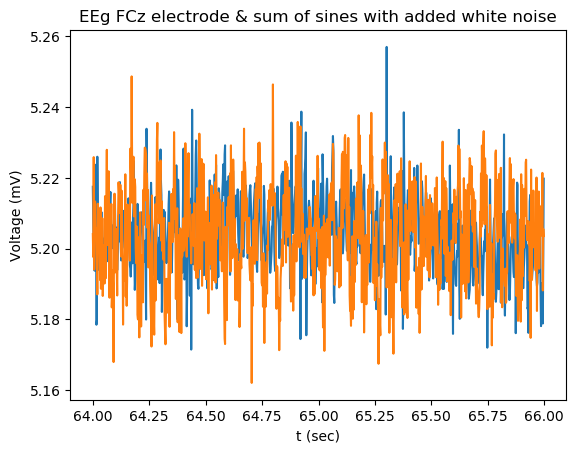

In [9]:
plt.plot(t,key_data[chosenElec][start_ind:end_ind])

sum_of_sines_with_noise = sum_of_sines + amp1*np.random.randn(np.size(sum_of_sines))
plt.plot(t,sum_of_sines_with_noise)
plt.xlabel("t (sec)")
plt.ylabel("Voltage (mV)")
plt.title("EEg FCz electrode & sum of sines with added white noise")


sum of sines - also add 32 & 36

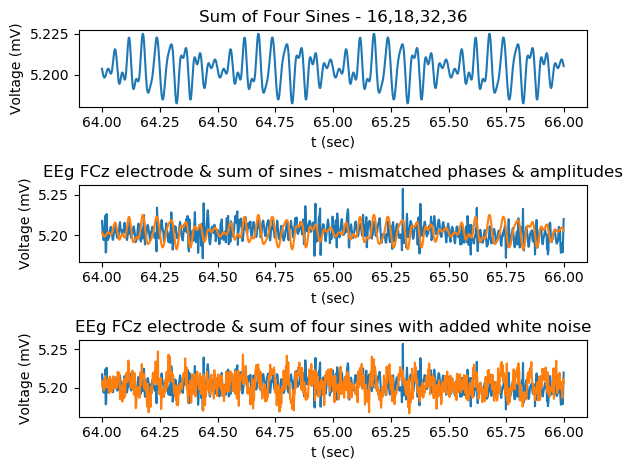

In [10]:
chosenElec = 1 # FCz
f_32 = 32
f_36 = 36
#rand_ph_32 = 2 * np.pi * np.random.rand(1)
#rand_ph_36 = 2 * np.pi * np.random.rand(1)
sine_32 = np.sin(2 * np.pi * f_32 * t + rand_ph);
sine_36 = np.sin(2 * np.pi * f_36 * t);
amp32 = np.random.uniform(low=amp1/2, high=amp1/2) ##check later - calculation of amplitude of harmonic wave
amp36 = np.random.uniform(low=amp1/8, high=amp1/2)##check later - calculation of amplitude of harmonic wave

# the key_data average is set as the DC level for the sum of sines
sum_of_four_sines = np.average(key_data[chosenElec][start_ind:end_ind]) + amp1*(sine_16 + amp2/amp1*sine_18)+amp32*sine_32+amp36*sine_36

fig, (ax_sines, ax_signal,ax_foursines) = plt.subplots(3, 1,sharex=True)

plt.subplot(3, 1, 1)
plt.plot(t,sum_of_four_sines)
plt.title('Sum of Four Sines - 16,18,32,36')
plt.xlabel('t (sec)')
plt.ylabel('Voltage (mV)')

plt.subplot(3, 1, 2)
plt.plot(t,key_data[chosenElec][start_ind:end_ind])
plt.plot(t,sum_of_four_sines)
plt.title('EEg FCz electrode & sum of sines - mismatched phases & amplitudes')
plt.xlabel('t (sec)')
plt.ylabel('Voltage (mV)')


plt.subplot(3, 1, 3)
plt.plot(t,key_data[chosenElec][start_ind:end_ind])
sum_of_four_sines_with_noise = sum_of_sines + amp1*np.random.randn(np.size(sum_of_four_sines))
plt.plot(t,sum_of_four_sines_with_noise)
plt.xlabel("t (sec)")
plt.ylabel("Voltage (mV)")
plt.title("EEg FCz electrode & sum of four sines with added white noise")

plt.tight_layout()
plt.show()

# Cross Correlation


Before Filtering

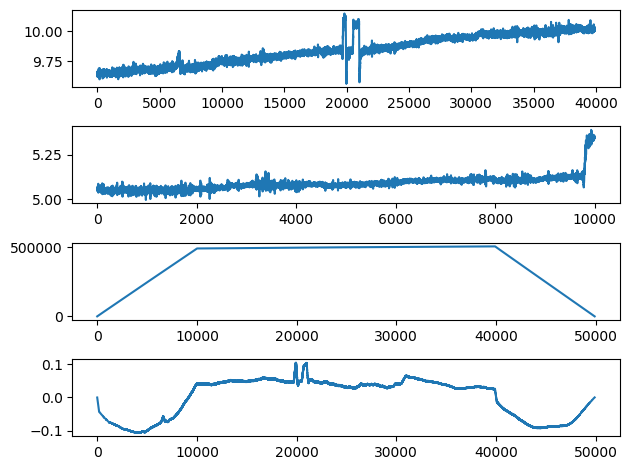

In [11]:
fig, (ax_sig, ax_kernel, ax_corr,ax_norm_corr) = plt.subplots(4, 1, sharex=False)

### Correl
elec_1=key_data[2][100:40000]
elec_2=key_data[1][10000:20000]
norm_elec_1 = (elec_1 - np.mean(elec_1)) / (np.std(elec_1) * len(elec_1))
norm_elec_2 = (elec_2 - np.mean(elec_2)) / (np.std(elec_2))


cross_corr_cz = signal.correlate(elec_1,elec_2,mode='full')
cross_corr_norm = signal.correlate(norm_elec_1, norm_elec_2, 'full')
#time = np.arange(0,5000,1)
ax_sig.plot(key_data[2][100:40000])
ax_kernel.plot(key_data[1][10000:20000])
ax_corr.plot(cross_corr_cz)
ax_norm_corr.plot(cross_corr_norm)

plt.tight_layout()
plt.show()

After Filtering

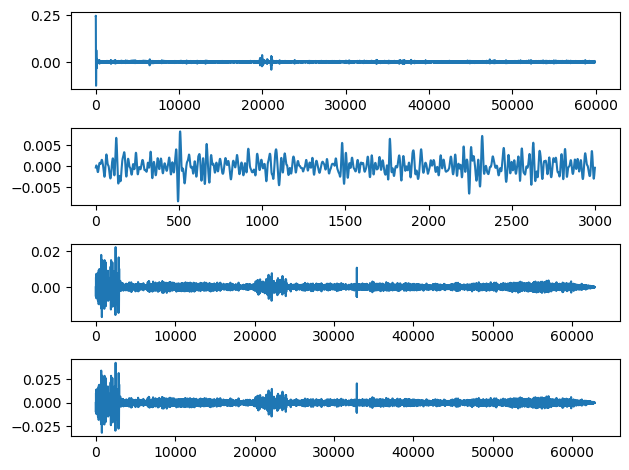

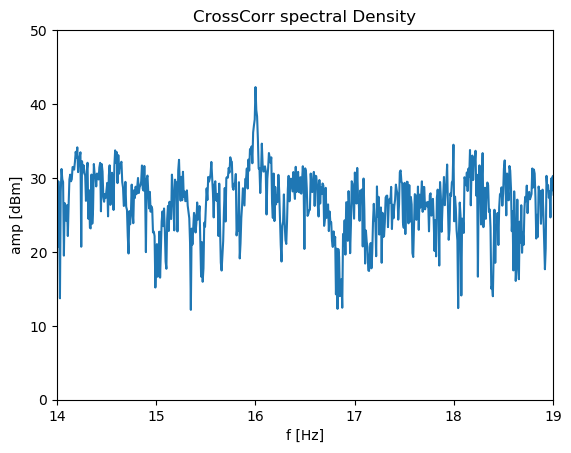

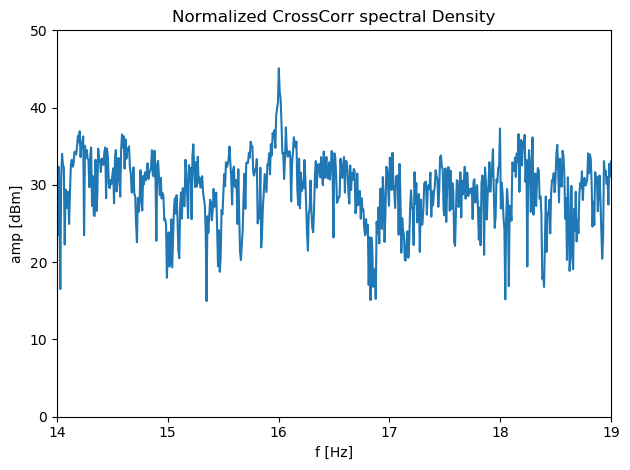

In [12]:
### Correl
kenrel_start_index = 30000
kenrel_stop_index = 33000
fft_elec_1=filtered_key_data[1][100:60000]
fft_elec_2=filtered_key_data[1][kenrel_start_index:kenrel_stop_index]

#Normlizing

norm_fft_elec_1 = (fft_elec_1 - np.mean(fft_elec_1)) / (np.std(fft_elec_1) * len(fft_elec_1))
norm_fft_elec_2 = (fft_elec_2 - np.mean(fft_elec_2)) / (np.std(fft_elec_2))

#Cross-Corr
cross_corr_cz = signal.correlate(fft_elec_1,fft_elec_2,mode='full')
cross_corr_fft = fft.fftshift(fft.fft(cross_corr_cz))
cross_corr_fft_db=10*np.log10(np.abs(cross_corr_fft))+30

#Norm Cross-Corr
norm_cross_corr_cz = signal.correlate(norm_fft_elec_1,norm_fft_elec_2,mode='full')
norm_cross_corr_fft = fft.fftshift(fft.fft(norm_cross_corr_cz))
norm_cross_corr_fft_db=10*np.log10(np.abs(norm_cross_corr_fft))+30

f_axis = np.linspace(-fs/2,fs/2,np.size(cross_corr_fft))

fig, (ax_sig, ax_kernel, ax_corr,ax_norm_corr) = plt.subplots(4, 1,sharex=False)
ax_sig.plot(fft_elec_1)
ax_kernel.plot(fft_elec_2)
ax_corr.plot(cross_corr_cz)
ax_norm_corr.plot(norm_cross_corr_cz)
plt.tight_layout()
fig = plt.figure()
plt.plot(f_axis,(cross_corr_fft_db))
plt.xlim(left=14,right=19)
plt.ylim(bottom = 0, top=50)
plt.title('CrossCorr spectral Density')
plt.xlabel('f [Hz]')
plt.ylabel('amp [dBm]')

fig2 = plt.figure()
plt.plot(f_axis,(norm_cross_corr_fft_db))
plt.xlim(left=14,right=19)
plt.ylim(bottom = 0, top=50)
plt.title('Normalized CrossCorr spectral Density')
plt.xlabel('f [Hz]')
plt.ylabel('amp [dBm]')
##### Notice - the given example doenst have 18Hz Freq
plt.tight_layout()
plt.show()


# SNR - getSNR

getSNR function takes fft of a signal and the requested frequencies and, splits the fft into noise and signal frequencies.
Computes the energy of the signal and of the noise and computes the SNR.

Requested frequncies might not be on the fft grid. We defined the signal frequencies as freqs with gaps of up to one sample from the requested freqs.

In [13]:
def getSNR(sig_fft,sig_freqs):
  n = np.size(sig_fft)
  f_axis = np.linspace(-fs/2, fs/2, np.size(sig_fft)+1)
  f_axis = f_axis[0:-1]
  noise_freqs = f_axis[(f_axis >= 0)]
  freq_step = fs/np.size(f_axis)
  sig_freqs_on_axis = [] #freqs axis is not accurate to sig_freqs - this array will hold the matching freqs on the axis 
  for freq in sig_freqs:
    sig_freqs_on_axis = np.append(sig_freqs_on_axis,(f_axis[(f_axis > freq-freq_step) & (f_axis < freq + freq_step)]))
    noise_freqs = noise_freqs[(noise_freqs < freq-freq_step) | (noise_freqs > freq + freq_step)]
  noise_intersect = np.intersect1d(f_axis,noise_freqs,return_indices=True)
  noise_indices = noise_intersect[1]
  sig_intersect = np.intersect1d(f_axis,sig_freqs_on_axis,return_indices=True)
  sig_indices = sig_intersect[1]
  noisePower = np.sum(np.abs(sig_fft[noise_indices]))
  sigPower = np.sum(np.abs(sig_fft[sig_indices]))
  SNR = 10*np.log10(sigPower/noisePower)
  return SNR



#getSNR check - testing on one segment
This section is just testing that the SNR functions work. 

-20.312299175869605


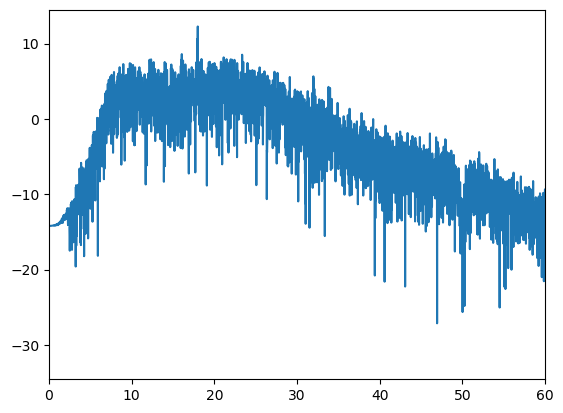

In [14]:
start_ind = 210000
end_ind = 240000
t = np.linspace(start_ind,end_ind,end_ind - start_ind+1) * 1/fs;
t = t[0:-1]
f_16 = 16
f_18 = 18

#rand_ph = 0#2 * np.pi * np.random.rand(1)
#sine_16 = np.sin(2 * np.pi * f_16 * t + rand_ph);
#sine_18 = np.sin(2 * np.pi * f_18 * t);

sine_fft = fft.fftshift(fft.fft(sine_16))

#fig2 = plt.figure()

sigFFT = fft.fftshift(fft.fft(filtered_key_data[chosenElec][start_ind:end_ind]))
f_axis = np.linspace(-fs/2, fs/2, np.size(sigFFT)+1)
f_axis = f_axis[0:-1]
plt.plot(f_axis,10*np.log10(np.abs(sigFFT)))
plt.xlim(left=0,right=60)
mytry = getSNR(sigFFT,[16,18])
print(mytry)
#f_axis = np.linspace(-fs/2, fs/2, np.size(f)+1)
#f_axis = f_axis[0:-1]
#noise_freqs = f_axis[(f_axis >= 0) & ((f_axis < 15.9) | ((f_axis > 16.1) & (f_axis < 17.9)) | (f_axis > 18.1))]


# getSNR check entire signal - split into one minute segments
In this section you can see SNR for our signal with and without filtering.


In [15]:
# 30,000 samples - one minute sample
start_ind = 0 
end_ind = 30000

f_16 = 16
f_18 = 18
# arrays for data
SNR_filtered_arr=[]
SNR_unfiltered_arr=[]
start_ind_arr=[]
end_ind_arr=[]

while (end_ind < 240000):# stop after 24000 samples
  t = np.linspace(start_ind,end_ind,end_ind - start_ind+1) * 1/fs;
  t = t[0:-1]
  sigFFT_filt = fft.fftshift(fft.fft(filtered_key_data[chosenElec][start_ind:end_ind])) #choose filtered data
  sigFFT_unfilt = fft.fftshift(fft.fft(key_data[chosenElec][start_ind:end_ind])) #choose unfiltered data
  SNR_tmp = getSNR(sigFFT_filt,[f_16,f_18])
  SNR_filtered_arr.append(SNR_tmp)
  SNR_tmp = getSNR(sigFFT_unfilt,[f_16,f_18])
  SNR_unfiltered_arr.append(SNR_tmp)
  
  start_ind_arr.append(start_ind)
  end_ind_arr.append(end_ind)

  start_ind = start_ind + 10000 
  end_ind = end_ind +  10000 #10000 samples step 

#Define dataframe for all the collected data
df = pd.DataFrame(list(zip(SNR_filtered_arr, SNR_unfiltered_arr,start_ind_arr,end_ind_arr)), 
               columns =['SNR Filtered', 'SNR Unfiltered' , 'Start Ind' , 'End Ind']) 
df.sort_values(by=['SNR Filtered'], inplace=True, ascending=False)
df.head(21)

,SNR Filtered,SNR Unfiltered,Start Ind,End Ind
5,-16.715325,-37.556881,50000,80000
3,-16.728733,-37.547276,30000,60000
4,-16.760445,-37.488888,40000,70000
6,-17.585902,-38.297097,60000,90000
7,-17.818665,-38.403077,70000,100000
9,-18.036495,-38.150702,90000,120000
8,-18.175440,-38.585829,80000,110000
17,-18.211385,-36.063651,170000,200000
18,-18.215648,-36.098294,180000,210000
10,-18.386325,-38.300390,100000,130000


# getSNR check - sine signal SNR & sine signal with noise SNR
In this section you can see SNR for sine signal with and without the noise.
You can see the signal itself under the section "Understanding the sum of sines behaviour"

In [16]:
t = np.linspace(start_ind,end_ind,end_ind - start_ind+1) * 1/fs;
t = t[0:-1]
f_16 = 16
f_18 = 18

sum_of_sines_with_noise = sum_of_sines_with_noise - np.average(sum_of_sines_with_noise)
sine_fft_noise = fft.fftshift(fft.fft(sum_of_sines_with_noise))

sum_of_sines= sum_of_sines - np.average(sum_of_sines_with_noise)
sine_fft = fft.fftshift(fft.fft(sum_of_sines))

#f_axis = np.linspace(-fs/2, fs/2, np.size(sine_fft)+1)
#f_axis = f_axis[0:-1]
#plt.plot(f_axis,(np.abs(sine_fft)))
#plt.xlim(left=0,right=60)

noisy_SNR = getSNR(sine_fft_noise,[16,18])
print('noisy SNR:',noisy_SNR )
sine_SNR = getSNR(sine_fft,[16,18])
print('sine SNR:',sine_SNR )

noisy SNR: -12.06723359216721
sine SNR: -27.815674670029154



# SNR from AutoCorrelation- Doesnt Work

NameError: name 'auto_corr' is not defined

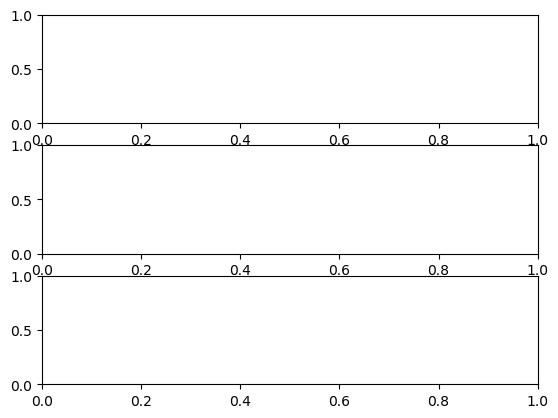

In [17]:
fig, (ax_sig, ax_kernel, ax_corr) = plt.subplots(3, 1, sharex=False)

### Correl
start_ind = 140000
end_ind = 160000
elec_1=filtered_key_data[1][start_ind:end_ind]
#elec_2=key_data[2][start_ind:end_ind]
norm_elec_1 = (elec_1 - np.mean(elec_1)) / (np.std(elec_1) * len(elec_1))
#norm_elec_2 = (elec_2 - np.mean(elec_2)) / (np.std(elec_2))


auto_corr = signal.correlate(filtered_key_data[1][start_ind:end_ind],elec_1,mode='full')/np.size(auto_corr)
auto_corr_norm = signal.correlate(norm_elec_1,norm_elec_1,mode='full')
#time = np.arange(0,5000,1)
ax_sig.plot(filtered_key_data[1][start_ind:end_ind+10000])
ax_kernel.plot(elec_1)
ax_corr.plot(auto_corr)

plt.tight_layout()
plt.show()

corr_fft = fft.fftshift(fft.fft(auto_corr))
f_axis = np.linspace(-fs/2,fs/2,np.size(corr_fft))
#time = np.arange(0,5000,1)
fig = plt.figure()
plt.plot(f_axis,(10*np.log10(np.abs(corr_fft))+30))
plt.xlim(left=0,right=40)
plt.ylim(bottom=-40)
plt.title('AutoCorr spectral Density')
plt.xlabel('f [Hz]')
plt.ylabel('amp [dBm]')
##### Notice - the given example doenst have 18Hz Freq
plt.tight_layout()
plt.show()